# Homework 4
#### Pierre-Antoine Desplaces, Anaïs Ladoy, Lou Richard


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency
import seaborn as sns
import math

## <b> <font color='purple'>Question 1 - Propensity score matching</font> </b>
In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

### <b> <font color='purple'>1.1 - A naive analysis</font> </b>
<b> Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis? <b>

In [2]:
# Load data
lalonde_data=pd.read_csv('lalonde.csv',index_col=0)
lalonde_data.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [3]:
# Create two subsets of the dataset (one for each group)
data_control=lalonde_data[lalonde_data.treat==0]
data_treat=lalonde_data[lalonde_data.treat==1]

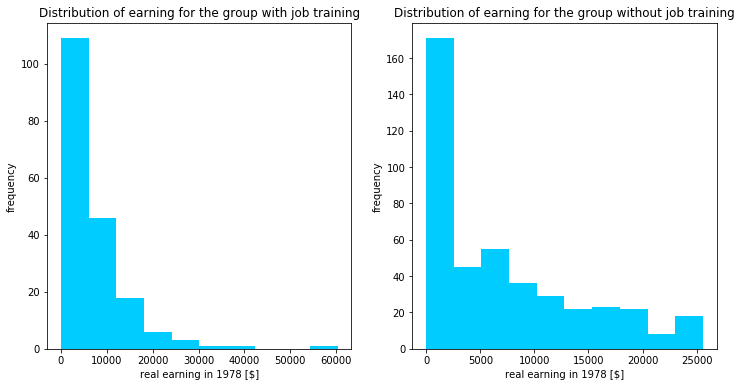

In [4]:
# Visualization of the respective distribution of the outcome variable for the two groups with an histogram 
fig = plt.figure(figsize=(12, 6))

# Histrogram for the treated group
plt.subplot(1,2,1)
plt.hist(data_treat.re78,color='#00ccff')
plt.title('Distribution of earning for the group with job training')
plt.xlabel('real earning in 1978 [$]')
plt.ylabel('frequency')

# Histrogram for the control group
plt.subplot(1,2,2)
plt.hist(data_control.re78,color='#00ccff')
plt.title('Distribution of earning for the group without job training')
plt.xlabel('real earning in 1978 [$]')
plt.ylabel('frequency')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


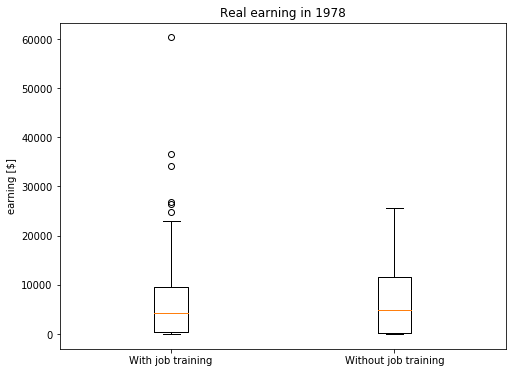

In [5]:
# Boxplots of the outcome variable (earning in 1978) for the two groups
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
plt.boxplot([data_treat.re78, data_control.re78])
ax.set_title('Real earning in 1978')
ax.set_xticklabels(['With job training','Without job training'])
ax.set_ylabel('earning [$]')
plt.show()

In [6]:
# Compute the number of people in each group (rows) where earning in 1978 is equal to 0 and the relative proportion
print('Number of people in the treatment group with no earnings in 1978 : {} ({}%)'.format(len(data_treat[data_treat.re78==0]),round(len(data_treat[data_treat.re78==0])/len(data_treat)*100,2)))
print('Number of people in the control group with no earnings in 1978 : {} ({}%)'.format(len(data_control[data_control.re78==0]),round(len(data_control[data_control.re78==0])/len(data_control)*100,2)))

Number of people in the treatment group with no earnings in 1978 : 45 (24.32%)
Number of people in the control group with no earnings in 1978 : 98 (22.84%)


First, we can see that the two distributions are highly skewed which is common for incomes data. Furthermore, a lot of people (~20% of people in each group) have earnings equal to 0, it must mean that they are unemployed in 1978.

The earnings tend to go higher for people with job training as we can notice a lot of outliers (3 peoples were earning more than 35'000$ in 1978). In comparison, the earnings are more concencatred for the control group (no outliers).

In [7]:
# Decriptive statistics for the distribution of the outcome variable
pd.DataFrame({'Without job training' :data_control.re78.describe(), 'With job training':data_treat.re78.describe()}).round(2)

,With job training,Without job training
count,185.00,429.00
mean,6349.14,6984.17
std,7867.40,7294.16
min,0.00,0.00
25%,485.23,220.18
50%,4232.31,4975.50
75%,9643.00,11688.82
max,60307.93,25564.67


This data frame summarize the information contained in the previous plots. 
We can note that the mean income is a little bit higher for the people that didn't participate to a job training but the maximum income is much bigger in the treatment group (34 743$ of difference).


As a naive conclusion, we could say that we have more chance to be rich with a job training program.

### <b> <font color='purple'>1.2 - A closer look at the data</font> </b>
<b> You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis. <b>

In [8]:
print('Range of values for each feature in the dataset:')
for column in lalonde_data[lalonde_data.columns[1:]] :
    print('{} : {} - {}'.format(column,min(lalonde_data[column]),max(lalonde_data[column])))

Range of values for each feature in the dataset:
age : 16 - 55
educ : 0 - 18
black : 0 - 1
hispan : 0 - 1
married : 0 - 1
nodegree : 0 - 1
re74 : 0.0 - 35040.07
re75 : 0.0 - 25142.24
re78 : 0.0 - 60307.93


The methods to analyse the distribution between two groups change according the type of variables and in our case, we will make a distinction between the binary variables (race, married and no degree) and the continuous variables (age, education level and earnings). 

In order to have an observational study as close as possible to a experimental study, people needs to be assigned almost by chance to the Job Training program (treatment). Thus ideally, the covariates shouldn't have an influence about the assignement to a the treatment or control group.

We will compute for each type of variables some basic statistics and we will assess the statistical dependance between each covariate and the attribution to the treatment group, both with statistical test and with the computation of the standardized difference.


#### Categorical features (Race, Married and No degree)
The goal with categorical variables is to compare the proportions of each feature between the two groups.
In order to compare the prevalence of each binary covariate (black, hispan, married and no degree peoples) between the two groups, we will use a Chi-squared test which is defined as :

\begin{align}
\chi^2 & = \sum_{all cells} \frac {(Observed_f - Expected_f)^2}{Expected_f}\\
\end{align}

For example, if we take the first binary variable in our data frame, corresponding to the number of black people. Our 2x2 contingency table will be composed of the number of Black and Not Black present in the Control and Treatment groups and the Chi-squared test hypotheses will be :  

$H_{0}$ : The proportion of people assigned to the job training is independent of the fact that they are black or not.  
$H_{1}$ : The proportion of people assigned to the job training is associated to the fact that they are black or not.

Given a significance level of 5%, we can reject the null hypothesis ($H_{0}$) if the $chi^2$ test returns a p-value<0.05.

In [9]:
# Compute the percentage of each covariate in the control group and in the treatment group
control_cat=data_control[['black','hispan','married','nodegree']].apply(lambda x:(sum(x)/len(x))*100,axis=0).round(2)
treat_cat=data_treat[['black','hispan','married','nodegree']].apply(lambda x:(sum(x)/len(x))*100,axis=0).round(2)
data_cat=pd.DataFrame(np.column_stack([control_cat, treat_cat]),index=control_cat.keys(),columns=['Without Job Training (N=429)','With Job Training (N=185)'])
data_cat.index.name='Variable'
data_cat

,Without Job Training (N=429),With Job Training (N=185)
Variable,,
black,20.28,84.32
hispan,14.22,5.95
married,51.28,18.92
nodegree,59.67,70.81


In [10]:
# Chi-square test of independence between the table of contingency for two categorical variables 
def chisquare_test(var1,var2):
    contingency_table=pd.crosstab(var1,var2)
    p_value=stats.chi2_contingency(contingency_table)[1]
    if p_value<0.05:
        test='Significant'
    else:
        test='Not significant'
    return test

In [11]:
# Compute the chi-square test for each categorical feature and add it to the dataframe
lalonde_cat=lalonde_data[['black','hispan','married','nodegree']]
data_cat['Statistic Test Significance']=lalonde_cat.apply(lambda x: chisquare_test(lalonde_data['treat'],x), axis=0)

The standardized difference compares the difference in means between two groups in units of the grouped standard deviation. This metric has the main advantage to not be influenced by the group size and allow the comparison between different variables (no units).

In [12]:
# Standardized difference for categorical variables
def stand_diff_cat(p_c,p_t):
    # Convert the percentage in proportions
    p_c=p_c/100
    p_t=p_t/100
    diff=(p_t-p_c)/(np.sqrt((p_t*(1-p_t)+p_c*(1-p_c))/2))
    return diff

In [13]:
# Compute the standardized difference between for each categorical variable
data_cat['Standardized difference']=stand_diff_cat(data_cat['Without Job Training (N=429)'],data_cat['With Job Training (N=185)'])
data_cat

,Without Job Training (N=429),With Job Training (N=185),Statistic Test Significance,Standardized difference
Variable,,,,
black,20.28,84.32,Significant,1.670617
hispan,14.22,5.95,Significant,-0.277259
married,51.28,18.92,Significant,-0.720679
nodegree,59.67,70.81,Significant,0.235548


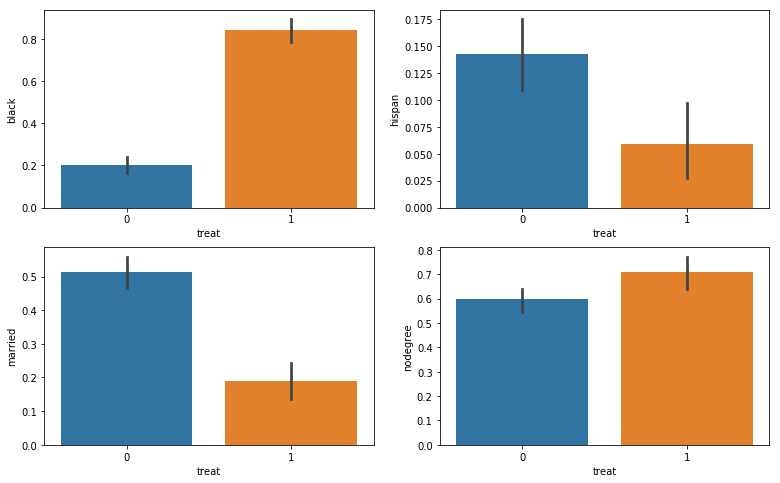

In [14]:
# Compare the distribution of the different continuous features between the two groups (treat and no treat)
fig = plt.figure(1, figsize=(13, 8))
plt.subplot(2,2,1)
sns.barplot(x="treat",y="black",data=lalonde_data)
plt.subplot(2,2,2)
sns.barplot(x="treat",y="hispan",data=lalonde_data)
plt.subplot(2,2,3)
sns.barplot(x="treat",y="married",data=lalonde_data)
plt.subplot(2,2,4)
sns.barplot(x="treat",y="nodegree",data=lalonde_data)
plt.show()

All the variables are significant, it means we can reject the hypothesis that the covariate is independant to the treatment assignation. Furthermore, we can notice some important differences between the mean in the two groups.

#### Continuous features (Age, Education level and Earnings)

In [15]:
control_cont=data_control[['age','educ','re74','re75','re78']].groupby(lambda idx: 0).agg(['mean','std']).round(2).transpose()
treat_cont=data_treat[['age','educ','re74','re75','re78']].groupby(lambda idx: 0).agg(['mean','std']).round(2).transpose()
data_cont=pd.concat([control_cont,treat_cont],axis=1)
data_cont.columns=['Without Job Training (N=429)','With Job Training (N=185)']
data_cont

Without Job Training (N=429)  With Job Training (N=185)
age  mean                         28.03                      25.82
     std                          10.79                       7.16
educ mean                         10.24                      10.35
     std                           2.86                       2.01
re74 mean                       5619.24                    2095.57
     std                        6788.75                    4886.62
re75 mean                       2466.48                    1532.06
     std                        3292.00                    3219.25
re78 mean                       6984.17                    6349.14
     std                        7294.16                    7867.40

The two sample t-test has the same goal as the Chi-squared test, meaning that it test the independance of covariates in the treatment assignation. We can reject the hypothesis that the covariate distribution has no influence on the assignation to treatment if the returned p-value is lower than 5%.

In [16]:
# Two sample t-test
def t_test(var1,var2):
    p_value=stats.ttest_ind(var1, var2, equal_var=False)[1]
    if p_value<0.05:
        test='Significant'
    else:
        test='Not significant'
    return test

In [17]:
lalonde_cont=lalonde_data[['age','educ','re74','re75','re78']]
# Compute the two sample t-test for each continuous variable
t_test_res=lalonde_cont.apply(lambda x: chisquare_test(lalonde_data['treat'],x), axis=0)
# Add result to dataframe
data_cont.loc[[('age','mean'),('educ','mean'),('re74','mean'),('re75','mean'),('re78','mean')],'Test Significance']=list(zip(t_test_res))

In [18]:
# Standardized difference for continuous variables
def stand_diff_cont(x_c,sd_c,x_t,sd_t):
    diff=(x_t-x_c)/(np.sqrt((sd_t**2+sd_c**2)/2))
    return diff

In [19]:
# Compute the standardized difference for each continuous variable and add the result to the dataframe in the same time
data_cont.loc[('age','mean'),'Standardized difference']=stand_diff_cont(data_cont.loc[('age','mean'),'Without Job Training (N=429)'],data_cont.loc[('age','std'),'Without Job Training (N=429)'],data_cont.loc[('age','mean'),'With Job Training (N=185)'],data_cont.loc[('age','std'),'With Job Training (N=185)'])
data_cont.loc[('educ','mean'),'Standardized difference']=stand_diff_cont(data_cont.loc[('educ','mean'),'Without Job Training (N=429)'],data_cont.loc[('educ','std'),'Without Job Training (N=429)'],data_cont.loc[('educ','mean'),'With Job Training (N=185)'],data_cont.loc[('educ','std'),'With Job Training (N=185)'])
data_cont.loc[('re74','mean'),'Standardized difference']=stand_diff_cont(data_cont.loc[('re74','mean'),'Without Job Training (N=429)'],data_cont.loc[('re74','std'),'Without Job Training (N=429)'],data_cont.loc[('re74','mean'),'With Job Training (N=185)'],data_cont.loc[('re74','std'),'With Job Training (N=185)'])
data_cont.loc[('re75','mean'),'Standardized difference']=stand_diff_cont(data_cont.loc[('re75','mean'),'Without Job Training (N=429)'],data_cont.loc[('re75','std'),'Without Job Training (N=429)'],data_cont.loc[('re75','mean'),'With Job Training (N=185)'],data_cont.loc[('re75','std'),'With Job Training (N=185)'])
data_cont.loc[('re78','mean'),'Standardized difference']=stand_diff_cont(data_cont.loc[('re78','mean'),'Without Job Training (N=429)'],data_cont.loc[('re78','std'),'Without Job Training (N=429)'],data_cont.loc[('re78','mean'),'With Job Training (N=185)'],data_cont.loc[('re78','std'),'With Job Training (N=185)'])
data_cont = data_cont.replace(np.nan, '', regex=True)
data_cont


Without Job Training (N=429)  With Job Training (N=185)  \
age  mean                         28.03                      25.82   
     std                          10.79                       7.16   
educ mean                         10.24                      10.35   
     std                           2.86                       2.01   
re74 mean                       5619.24                    2095.57   
     std                        6788.75                    4886.62   
re75 mean                       2466.48                    1532.06   
     std                        3292.00                    3219.25   
re78 mean                       6984.17                    6349.14   
     std                        7294.16                    7867.40   

          Test Significance Standardized difference  
age  mean       Significant               -0.241354  
     std                                             
educ mean       Significant               0.0445018  
     std                                             
re74 mean   Not significant               -0.595753  
     std                                             
re75 mean   Not significant               -0.286999  
     std                                             
re78 mean   Not significant              -0.0837086  
     std

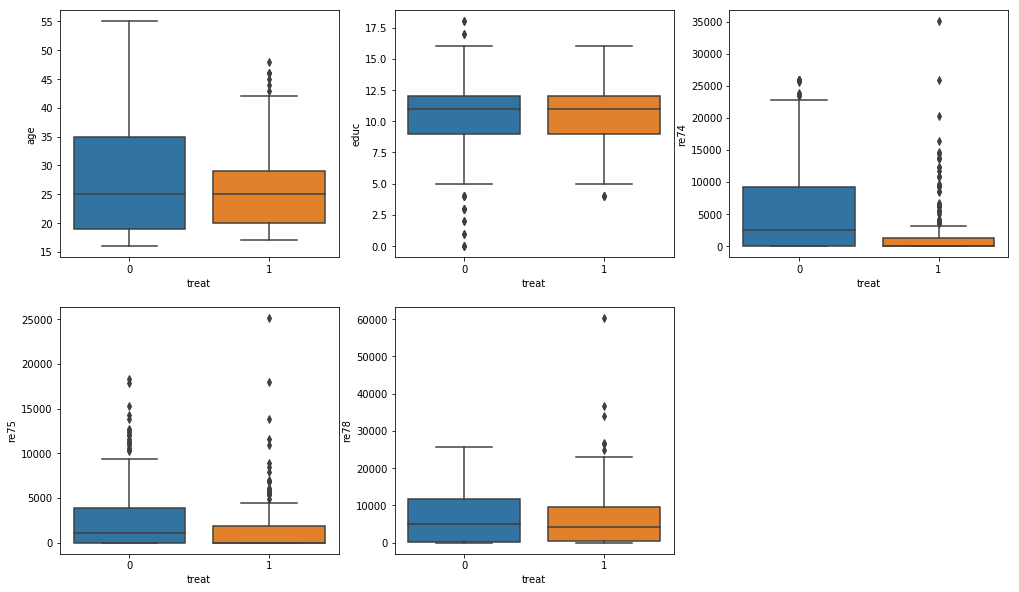

In [20]:
# Compare the distribution of the different continuous features between the two groups (treat and no treat)
fig = plt.figure(1, figsize=(17, 10))
plt.subplot(2,3,1)
sns.boxplot(x='treat', y='age', data=lalonde_data)
plt.subplot(2,3,2)
sns.boxplot(x='treat', y='educ', data=lalonde_data)
plt.subplot(2,3,3)
sns.boxplot(x='treat', y='re74', data=lalonde_data)
plt.subplot(2,3,4)
sns.boxplot(x='treat', y='re75', data=lalonde_data)
plt.subplot(2,3,5)
sns.boxplot(x='treat', y='re78', data=lalonde_data)
plt.show()

Concerning the continuous variables, only the age and the education level are not independant of the fact that people were assigned to a specific group.

### <b> <font color='purple'>1.3 - A propensity score model</font> </b>
<b> Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).) <b>

In [21]:
from sklearn import linear_model

Logistic regression used to estimate the probability of a binary response based on one or more predictor (or independent) variables (features). It allows one to say that the presence of a certain covariate increases the odds of a given outcome by a specific factor.

The propensity score allows to compare individuals that are the "closest" and in order to create an observational study as close as possible to an experiment, a pair of people with same propensity score have to be assigned one on each group (to reproduce the "chance attribution").

In [22]:
covariates=lalonde_data.drop(['treat'],axis=1)
covariates.head()

,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,
NSW1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,33,8,1,0,0,1,0.0,0.0,289.7899


In [23]:
# Create a Logistic Regression model
logistic = linear_model.LogisticRegression()

# Fit the model with X (covariates) and y (dependent variable)
X=lalonde_data.drop(['treat'],axis=1)
y=lalonde_data.treat
logistic = logistic.fit(X, y)

# check the accuracy on the training set
logistic.score(covariates, lalonde_data.treat)

# Probability estimates of the logistic regression that are equal to the propensity scores
# Select only the first column that corresponds to the probability of being selected in the treatment group (treat=1)
prop_score=logistic.predict_proba(X)[:,1]

In [24]:
# Add the propensity score for each point in our dataset
lalonde_data['Propensity Score']=prop_score.tolist()
lalonde_data.head(10)

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,Propensity Score
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.458074
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.151980
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.750966
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.674020
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.670590
NSW6,1,22,9,1,0,0,1,0.0,0.0,4056.4940,0.711254
NSW7,1,23,12,1,0,0,0,0.0,0.0,0.0000,0.649616
NSW8,1,32,11,1,0,0,1,0.0,0.0,8472.1580,0.660434
NSW9,1,22,16,1,0,0,0,0.0,0.0,2164.0220,0.583820


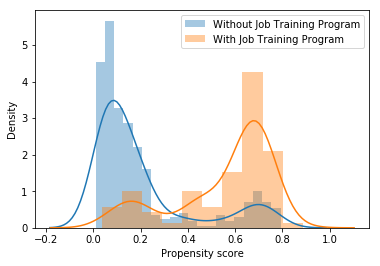

In [25]:
# Check that the propensity score is balanced across treatment and comparison group
data_control=lalonde_data[lalonde_data.treat==0]
data_treat=lalonde_data[lalonde_data.treat==1]
fig, ax = plt.subplots()
sns.distplot(data_control['Propensity Score'],label="Without Job Training Program",ax=ax)
sns.distplot(data_treat['Propensity Score'],label="With Job Training Program",ax=ax)
ax.legend()
ax.set_xlabel('Propensity score')
ax.set_ylabel('Density')
plt.show()

We can notice that the distribution of propensity score is not the same for the two groups so the observational study is far to looks like an experiment and we need a better matching of the propensity scores.

### <b> <font color='purple'>1.4 - Balancing the dataset via matching</font> </b>
<b> Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before? <b>

To compute a matching between the two groups, we are going to create a graph from the data, and then use the max_weight_matching function from the networkx package.

We first create our graph from the Lalonde data. Each node will have the attributes score containing its propensity score, and bipartite representing the categorical attribute 'treat'.

In [26]:
import networkx as nx
from networkx.algorithms import bipartite

G = nx.Graph()

for d in range(len(lalonde_data)):
    G.add_node(lalonde_data.index[d], score=lalonde_data.iloc[d]['Propensity Score'], bipartite=int(lalonde_data.iloc[d]['treat']))

We divide our nodes into two sets : those from the control group, and those from the treated group.

In [27]:
control_nodes = list(n for n in G if G.node[n]['bipartite']==0)
treat_nodes = G.nodes() - control_nodes

We then add an edge from every treat node to every control node, with a weight representing their propensity score difference. Since we want to get the maximum similarity between two subjects, we want to construct pairs of subjects such that the difference between their propensity score is minimal. The matching function we are going to use match two nodes if the weight of the edge connecting them is maximal. In order to have a maximum weight if two subjects are similar, we define this weight to be the absolute value of the difference of their score substracted to 1.

In [28]:
for t in treat_nodes:
    for c in control_nodes:
        edge_weight = 1 - abs(G.node[t]['score'] - G.node[c]['score'])
        G.add_edge(t,c, weight = edge_weight)

We can now use the max_weight_matching function of networkx to match each data point from the treated group with exactly one data point from the control group.

In [29]:
#import pickle

#matching = nx.max_weight_matching(G, maxcardinality=True)
#pickle.dump( matching, open( "matching.p", "wb" ) )

In [30]:
import pickle
matching = pickle.load(open( "matching.p", "rb" ) )

Our resulting matching dictionary contains the edges from the treated group to the control group, but also the reversed edges from the control group to the treated group. So we create a dataframe from our dictionary and keep only the first half.

In [31]:
df_matching = (pd.DataFrame.from_records([matching]).transpose())[0].reset_index()
first_half = int(len(matching)/2)
print("We check that the length of the dictionary is the two times the size of the treated group :")
print("size of dictionary / 2 = " + str(first_half)
        + " \nsize of treated group = " + str(len(data_treat)))

We check that the length of the dictionary is the two times the size of the treated group :
size of dictionary / 2 = 185 
size of treated group = 185


In [32]:
df_matching = df_matching[:first_half].copy()
df_matching.columns=['Treated group', 'Control group']
df_matching.head()

,Treated group,Control group
0,NSW1,PSID188
1,NSW10,PSID394
2,NSW100,PSID177
3,NSW101,PSID373
4,NSW102,PSID367


We can now compare the earnings between the two resulting groups.

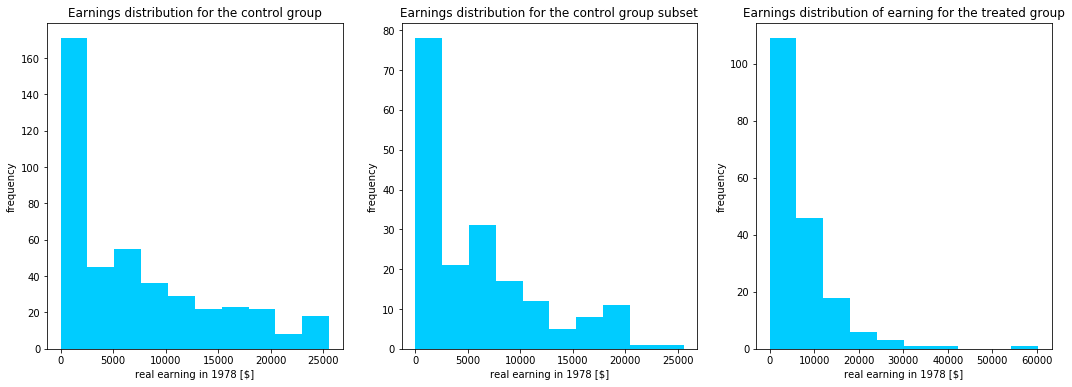

In [33]:
data_control_subset = data_control[data_control.index.isin(df_matching['Control group'])]
# Visualization of the respective distribution of the outcome variable for the two groups with an histogram 
fig = plt.figure(figsize=(18, 6))
# Histrogram for the control group
plt.subplot(1,3,1)
plt.hist(data_control.re78,color='#00ccff')
plt.title('Earnings distribution for the control group')
plt.xlabel('real earning in 1978 [$]')
plt.ylabel('frequency')
# Histrogram for the control group
plt.subplot(1,3,2)
plt.hist(data_control_subset.re78,color='#00ccff')
plt.title('Earnings distribution for the control group subset')
plt.xlabel('real earning in 1978 [$]')
plt.ylabel('frequency')
# Histrogram for the treated group
plt.subplot(1,3,3)
plt.hist(data_treat.re78,color='#00ccff')
plt.title('Earnings distribution of earning for the treated group')
plt.xlabel('real earning in 1978 [$]')
plt.ylabel('frequency')
plt.show()

In [34]:
control_cat_subset=data_control_subset[['black','hispan','married','nodegree']].apply(lambda x:(sum(x)/len(x))*100,axis=0).round(2)
data_cat_subset=pd.DataFrame(np.column_stack([control_cat_subset, treat_cat]),index=control_cat_subset.keys(),columns=['Without Job Training (N=185)','With Job Training (N=185)'])
data_cat_subset.index.name='Variable'
data_cat_subset

,Without Job Training (N=185),With Job Training (N=185)
Variable,,
black,47.03,84.32
hispan,10.27,5.95
married,18.38,18.92
nodegree,67.57,70.81


In [35]:
# Remove the unmatched subjects in the control group
lalonde_subset = lalonde_data[(lalonde_data.index.isin(df_matching['Control group'])) | (lalonde_data.index.isin(df_matching['Treated group']))]

# Compute the chi-square test for each categorical feature and add it to the dataframe
lalonde_cat_subset=lalonde_subset[['black','hispan','married','nodegree']]
data_cat_subset['Statistic Test Significance']=lalonde_cat_subset.apply(lambda x: chisquare_test(lalonde_subset['treat'],x), axis=0)

# Compute the standardized difference between for each categorical variable
data_cat_subset['Standardized difference']=stand_diff_cat(data_cat_subset['Without Job Training (N=185)'],data_cat_subset['With Job Training (N=185)'])
data_cat_subset

,Without Job Training (N=185),With Job Training (N=185),Statistic Test Significance,Standardized difference
Variable,,,,
black,47.03,84.32,Significant,0.853996
hispan,10.27,5.95,Not significant,-0.158746
married,18.38,18.92,Not significant,0.013864
nodegree,67.57,70.81,Not significant,0.070217


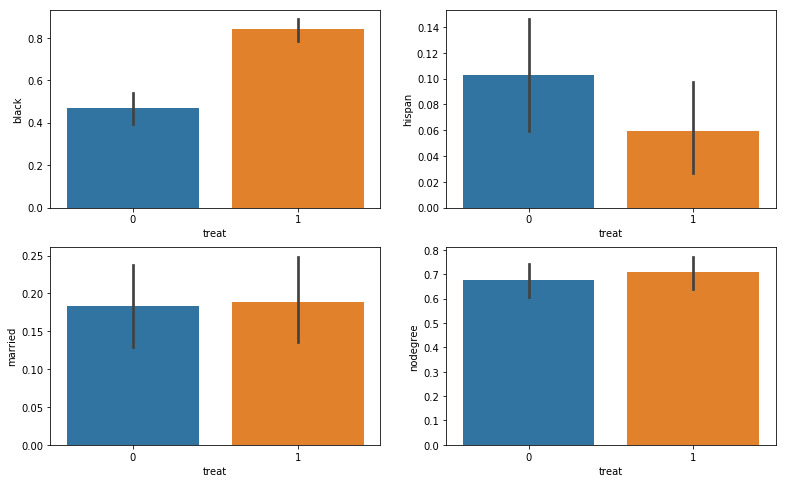

In [36]:
# Compare the distribution of the different continuous features between the two groups (treat and control)
fig = plt.figure(1, figsize=(13, 8))
plt.subplot(2,2,1)
sns.barplot(x="treat",y="black",data=lalonde_subset)
plt.subplot(2,2,2)
sns.barplot(x="treat",y="hispan",data=lalonde_subset)
plt.subplot(2,2,3)
sns.barplot(x="treat",y="married",data=lalonde_subset)
plt.subplot(2,2,4)
sns.barplot(x="treat",y="nodegree",data=lalonde_subset)
plt.show()

In [37]:
control_cont_subset=data_control_subset[['age','educ','re74','re75','re78']].groupby(lambda idx: 0).agg(['mean','std']).round(2).transpose()
data_cont_subset=pd.concat([control_cont_subset,treat_cont],axis=1)
data_cont_subset.columns=['Without Job Training (N=185)','With Job Training (N=185)']

lalonde_cont_subset=lalonde_subset[['age','educ','re74','re75','re78']]
# Compute the two samples t-test for each continuous variable
t_test_res_subset=lalonde_cont_subset.apply(lambda x: chisquare_test(lalonde_subset['treat'],x), axis=0)
# Add result to dataframe
data_cont_subset.loc[[('age','mean'),('educ','mean'),('re74','mean'),('re75','mean'),('re78','mean')],'Test Significance']=list(zip(t_test_res_subset))

# Compute the standardized difference for each continuous variable and add the result to the dataframe in the same time
data_cont_subset.loc[('age', 'mean'),'Standardized difference']=stand_diff_cont(data_cont_subset.loc[('age', 'mean'),'Without Job Training (N=185)'],data_cont_subset.loc[('age', 'std'),'Without Job Training (N=185)'],data_cont_subset.loc[('age','mean'),'With Job Training (N=185)'],data_cont_subset.loc[('age','std'),'With Job Training (N=185)'])
data_cont_subset.loc[('educ','mean'),'Standardized difference']=stand_diff_cont(data_cont_subset.loc[('educ','mean'),'Without Job Training (N=185)'],data_cont_subset.loc[('educ','std'),'Without Job Training (N=185)'],data_cont_subset.loc[('educ','mean'),'With Job Training (N=185)'],data_cont_subset.loc[('educ','std'),'With Job Training (N=185)'])
data_cont_subset.loc[('re74','mean'),'Standardized difference']=stand_diff_cont(data_cont_subset.loc[('re74','mean'),'Without Job Training (N=185)'],data_cont_subset.loc[('re74','std'),'Without Job Training (N=185)'],data_cont_subset.loc[('re74','mean'),'With Job Training (N=185)'],data_cont_subset.loc[('re74','std'),'With Job Training (N=185)'])
data_cont_subset.loc[('re75','mean'),'Standardized difference']=stand_diff_cont(data_cont_subset.loc[('re75','mean'),'Without Job Training (N=185)'],data_cont_subset.loc[('re75','std'),'Without Job Training (N=185)'],data_cont_subset.loc[('re75','mean'),'With Job Training (N=185)'],data_cont_subset.loc[('re75','std'),'With Job Training (N=185)'])
data_cont_subset.loc[('re78','mean'),'Standardized difference']=stand_diff_cont(data_cont_subset.loc[('re78','mean'),'Without Job Training (N=185)'],data_cont_subset.loc[('re78','std'),'Without Job Training (N=185)'],data_cont_subset.loc[('re78','mean'),'With Job Training (N=185)'],data_cont_subset.loc[('re78','std'),'With Job Training (N=185)'])
data_cont_subset = data_cont_subset.replace(np.nan, '', regex=True)
data_cont_subset

Without Job Training (N=185)  With Job Training (N=185)  \
age  mean                         23.17                      25.82   
     std                           9.34                       7.16   
educ mean                          9.86                      10.35   
     std                           2.78                       2.01   
re74 mean                       2268.39                    2095.57   
     std                        4266.74                    4886.62   
re75 mean                       1670.14                    1532.06   
     std                        2734.93                    3219.25   
re78 mean                       5828.58                    6349.14   
     std                        6094.31                    7867.40   

          Test Significance Standardized difference  
age  mean       Significant                0.318445  
     std                                             
educ mean   Not significant                   0.202  
     std                                             
re74 mean   Not significant              -0.0376747  
     std                                             
re75 mean   Not significant              -0.0462282  
     std                                             
re78 mean   Not significant               0.0739755  
     std

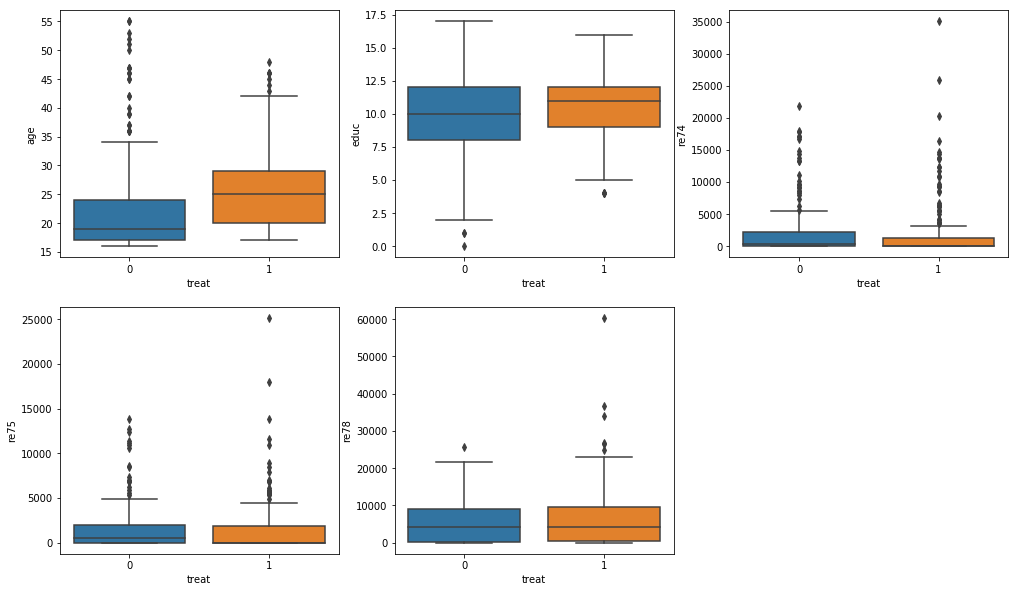

In [38]:
# Compare the distribution of the different continuous features between the two groups (treat and control)
fig = plt.figure(1, figsize=(17, 10))
plt.subplot(2,3,1)
sns.boxplot(x='treat', y='age', data=lalonde_subset)
plt.subplot(2,3,2)
sns.boxplot(x='treat', y='educ', data=lalonde_subset)
plt.subplot(2,3,3)
sns.boxplot(x='treat', y='re74', data=lalonde_subset)
plt.subplot(2,3,4)
sns.boxplot(x='treat', y='re75', data=lalonde_subset)
plt.subplot(2,3,5)
sns.boxplot(x='treat', y='re78', data=lalonde_subset)
plt.show()


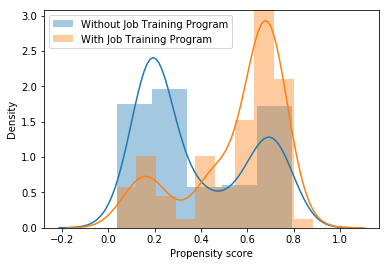

In [39]:
# Check that the propensity score is balanced across treatment and comparison group
fig, ax = plt.subplots()
sns.distplot(data_control_subset['Propensity Score'],label="Without Job Training Program",ax=ax)
sns.distplot(data_treat['Propensity Score'],label="With Job Training Program",ax=ax)
ax.legend()
ax.set_xlabel('Propensity score')
ax.set_ylabel('Density')
plt.show()

Therefore, the appropriateness of the specification of the propensity score is assessed by examining the degree to which matching on the estimated propensity score has resulted in a matched sample in which the distribution of measured baseline covariates is similar between treated and untreated subjects (removed observed systematic differences between treated and untreated subjects)

### <b> <font color='purple'>1.5 - Balancing the groups further</font> </b>
<b> Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4. <b>

We observe on the last plot that the propensity score is still not enough balanced between the two groups. From the $\chi$-squared test on the categorical attributes, we note that the skin color is a significant variable. In order to extract valid conclusions, we need to take into account the skin color of the subjects during the matching. Therefore, we will proceed as in the previous question, but this time only connecting nodes if they have the same skin color in the original graph.

In [40]:
G = nx.Graph()

for d in range(len(lalonde_data)):
    G.add_node(lalonde_data.index[d], score=lalonde_data.iloc[d]['Propensity Score'], black=int(lalonde_data.iloc[d]['black']), bipartite=int(lalonde_data.iloc[d]['treat']))

# Divide the data into 4 subsets based on the treat and the black attribute
control_nodes_black = list(n for n in G if (G.node[n]['bipartite']==0)&(G.node[n]['black']==1))
treat_nodes_black = list(n for n in G if (G.node[n]['bipartite']==1)&(G.node[n]['black']==1))
control_nodes_white = list(n for n in G if (G.node[n]['bipartite']==0)&(G.node[n]['black']==0))
treat_nodes_white = list(n for n in G if (G.node[n]['bipartite']==1)&(G.node[n]['black']==0))

               
# Add edges between each group into the 'black subset'
for t in treat_nodes:
    for c in control_nodes_black:
        edge_weight = 1 - abs(G.node[t]['score'] - G.node[c]['score'])
        G.add_edge(t,c, weight = edge_weight)
               
# Add edges between each group into the 'white subset'
for t in treat_nodes_white:
    for c in control_nodes_white:
        edge_weight = 1 - abs(G.node[t]['score'] - G.node[c]['score'])
        G.add_edge(t,c, weight = edge_weight)

In [41]:
#new_matching = nx.max_weight_matching(G, maxcardinality=True)
#pickle.dump( new_matching, open( "matching2.p", "wb" ) )

In [42]:
new_matching = pickle.load(open("matching2.p", "rb"))

In [43]:
df_new_matching = (pd.DataFrame.from_records([new_matching]).transpose())[0].reset_index()
first_half = int(len(new_matching)/2)
df_new_matching = df_new_matching[:first_half].copy()
df_new_matching.columns=['Treated group', 'Control group']
print("Number of subjects from each group in the resulting matching : " + str(len(df_new_matching)))
df_new_matching.head()

Number of subjects from each group in the resulting matching : 116


,Treated group,Control group
0,NSW1,PSID238
1,NSW10,PSID394
2,NSW100,PSID208
3,NSW102,PSID389
4,NSW104,PSID423


Since there is less black people in the control group than in the treated group, our matching contains less subjects, as not all nodes in the treated set can match one control node. We obtain a dataframe matching 116 subjects from the treated group to 116 subjects from the control group.

Now let's take a look at the repartition for the two new groups.

In [44]:
data_control_subset2 = data_control[data_control.index.isin(df_new_matching['Control group'])]
control_cat_subset2=data_control_subset2[['black','hispan','married','nodegree']].apply(lambda x : (sum(x)/len(x))*100,axis=0).round(2)
data_treat_subset2 = data_treat[data_treat.index.isin(df_new_matching['Treated group'])]
treat_cat_subset2 = data_treat_subset2[['black', 'hispan', 'married','nodegree']].apply(lambda x : (sum(x)/len(x))*100,axis=0).round(2)
data_cat_subset2=pd.DataFrame(np.column_stack([control_cat_subset2, treat_cat_subset2]),index=control_cat_subset2.keys(),columns=['Without Job Training (N=116)','With Job Training (N=116)'])
data_cat_subset2.index.name='Variable'
data_cat_subset2

,Without Job Training (N=116),With Job Training (N=116)
Variable,,
black,75.00,75.00
hispan,5.17,9.48
married,26.72,25.86
nodegree,62.07,67.24


In [45]:
# Remove the unmatched subjects in the control group
lalonde_subset2 = lalonde_data[(lalonde_data.index.isin(df_new_matching['Control group'])) | (lalonde_data.index.isin(df_new_matching['Treated group']))]

# Compute the chi-square test for each categorical feature and add it to the dataframe
lalonde_cat_subset2=lalonde_subset2[['black','hispan','married','nodegree']]
data_cat_subset2['Statistic Test Significance']=lalonde_cat_subset2.apply(lambda x: chisquare_test(lalonde_subset2['treat'],x), axis=0)

# Compute the standardized difference between for each categorical variable
data_cat_subset2['Standardized difference']=stand_diff_cat(data_cat_subset2['Without Job Training (N=116)'],data_cat_subset2['With Job Training (N=116)'])
data_cat_subset2

,Without Job Training (N=116),With Job Training (N=116),Statistic Test Significance,Standardized difference
Variable,,,,
black,75.00,75.00,Not significant,0.000000
hispan,5.17,9.48,Not significant,0.165990
married,26.72,25.86,Not significant,-0.019537
nodegree,62.07,67.24,Not significant,0.108308


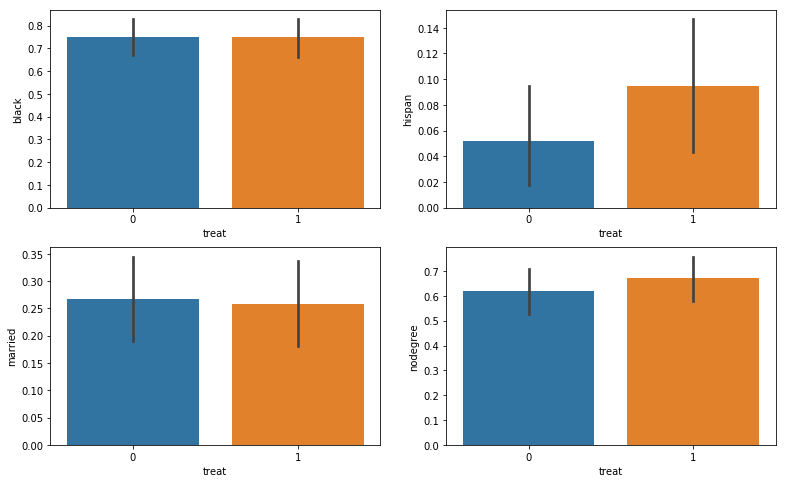

In [46]:
# Compare the distribution of the different continuous features between the two groups (treat and control)
fig = plt.figure(1, figsize=(13, 8))
plt.subplot(2,2,1)
sns.barplot(x="treat",y="black",data=lalonde_subset2)
plt.subplot(2,2,2)
sns.barplot(x="treat",y="hispan",data=lalonde_subset2)
plt.subplot(2,2,3)
sns.barplot(x="treat",y="married",data=lalonde_subset2)
plt.subplot(2,2,4)
sns.barplot(x="treat",y="nodegree",data=lalonde_subset2)
plt.show()

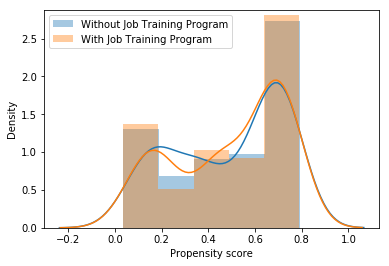

In [47]:
# Check that the propensity score is balanced across treatment and comparison group
fig, ax = plt.subplots()
sns.distplot(data_control_subset2['Propensity Score'],label="Without Job Training Program",ax=ax)
sns.distplot(data_treat_subset2['Propensity Score'],label="With Job Training Program",ax=ax)
ax.legend()
ax.set_xlabel('Propensity score')
ax.set_ylabel('Density')
plt.show()

From the plots and the $\chi$-squared test, we can assert that the two groups are better balanced with the matching considering the skin color of the subjects than with the previous matching only based on the propensity score.

### <b> <font color='purple'>1.6 - A less naive analysis</font> </b>
<b> Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program? <b>

As in the previous questions, we first compare the outcomes by displaying a histogram.

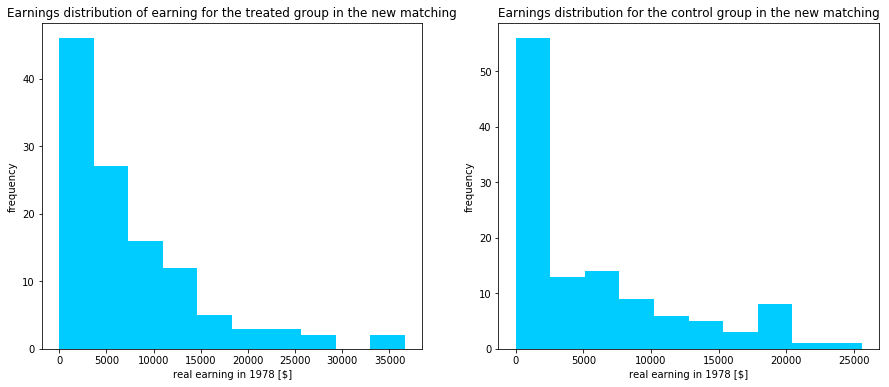

In [48]:
# Visualization of the respective distribution of the outcome variable for the two groups with an histogram 
fig = plt.figure(figsize=(15,6))

# Histrogram for the treated group
plt.subplot(1,2,1)
plt.hist(data_treat_subset2.re78,color='#00ccff')
plt.title('Earnings distribution of earning for the treated group in the new matching')
plt.xlabel('real earning in 1978 [$]')
plt.ylabel('frequency')
# Histrogram for the control group in the new matching
plt.subplot(1,2,2)
plt.hist(data_control_subset2.re78,color='#00ccff')
plt.title('Earnings distribution for the control group in the new matching')
plt.xlabel('real earning in 1978 [$]')
plt.ylabel('frequency')

plt.show()

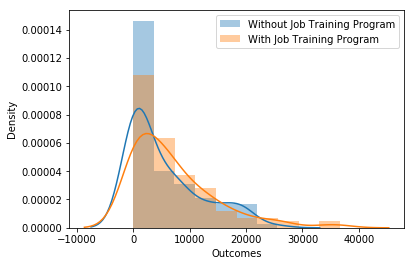

In [49]:
# Comparing the density of outcomes
fig, ax = plt.subplots()
sns.distplot(data_control_subset2['re78'],label="Without Job Training Program",ax=ax)
sns.distplot(data_treat_subset2['re78'],label="With Job Training Program",ax=ax)
ax.legend()
ax.set_xlabel('Outcomes')
ax.set_ylabel('Density')
plt.show()

In [50]:
lalonde_subset2[['treat','re78']].groupby(['treat']).describe()

re78                                                       \
       count         mean          std  min        25%        50%   
treat                                                               
0      116.0  5541.079675  6498.524197  0.0    0.00000  2742.6605   
1      116.0  7020.098252  7518.664135  0.0  977.05265  5026.9315   

                              
               75%       max  
treat                         
0       8942.09275  25564.67  
1      10011.04550  36646.95

If we group our values by the treat value, i.e. if the participated to the job training program or not, we observe that the treated group has higher outcomes than others, as 50% of the subjects out of the job training program earned less than 2700\$ against 5000\$ (almost twice as much) for the treated group.

In [51]:
# Divide the values of earnings in 1978 into intervals
int_re78 = pd.cut(lalonde_subset2.re78, 8)

earnings_intervals = lalonde_subset2['treat'].to_frame()
earnings_intervals['control'] = 1-earnings_intervals['treat']

earnings_intervals['Earnings intervals'] = (int_re78.to_frame())['re78']
earnings_intervals = earnings_intervals.groupby('Earnings intervals').sum()
earnings_intervals['treat %'] = earnings_intervals['treat']*100/len(lalonde_subset2)
earnings_intervals ['control %'] = earnings_intervals['control']*100/len(lalonde_subset2)
earnings_intervals['treat % inter'] = earnings_intervals['treat']*100/(earnings_intervals['treat']+earnings_intervals['control'])
earnings_intervals ['control % inter'] = 100 - earnings_intervals['treat % inter']
earnings_intervals.transpose()

Earnings intervals,"(-36.647, 4580.869]","(4580.869, 9161.738]","(9161.738, 13742.606]","(13742.606, 18323.475]","(18323.475, 22904.344]","(22904.344, 27485.212]","(27485.212, 32066.081]","(32066.081, 36646.95]"
treat,55.000000,27.000000,17.000000,7.000000,4.000000,4.000000,NaN,2.000000
control,68.000000,21.000000,9.000000,10.000000,7.000000,1.000000,NaN,0.000000
treat %,23.706897,11.637931,7.327586,3.017241,1.724138,1.724138,NaN,0.862069
control %,29.310345,9.051724,3.879310,4.310345,3.017241,0.431034,NaN,0.000000
treat % inter,44.715447,56.250000,65.384615,41.176471,36.363636,80.000000,NaN,100.000000
control % inter,55.284553,43.750000,34.615385,58.823529,63.636364,20.000000,NaN,0.000000


To confirm our hypothesis, we plot the average of outcomes for the two groups, and their earnings repartition.

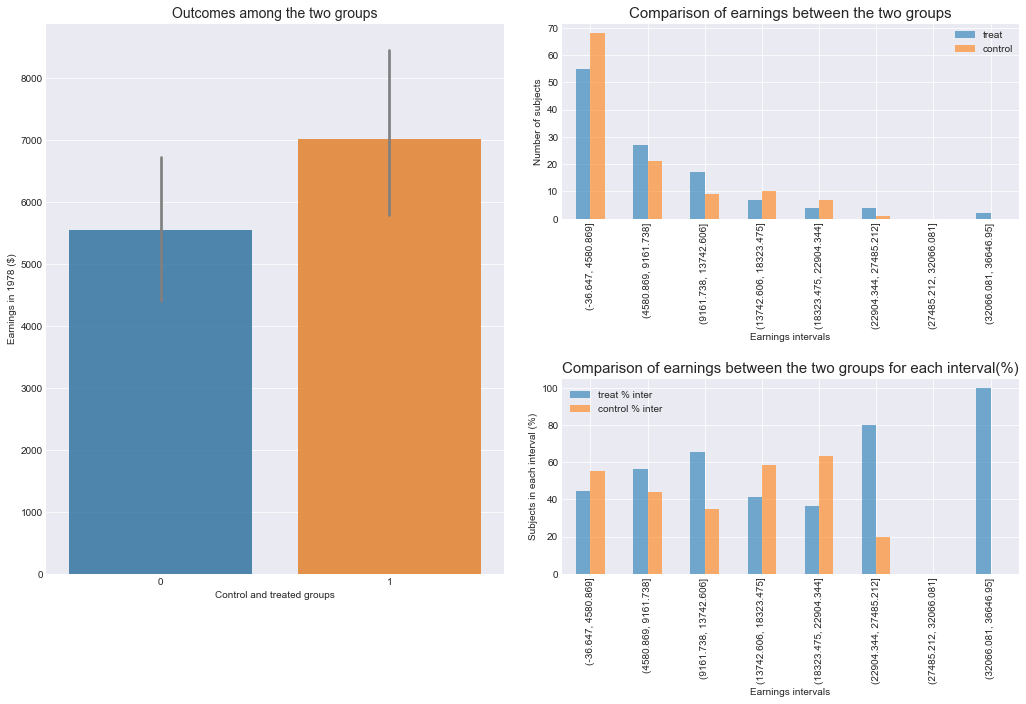

In [52]:
#fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(7,5))
fig = plt.figure(figsize=(15,10))
sns.set_style('darkgrid')

ax1 = plt.subplot(1,2,1)
sns.barplot(x="treat",y="re78", data=lalonde_subset2, ax=ax1, alpha=0.85,errcolor='.5')
ax1.legend()
ax1.set_xlabel('Control and treated groups')
ax1.set_ylabel('Earnings in 1978 ($)')
ax1.set_title('Outcomes among the two groups', fontsize=14)

ax2 = plt.subplot(2,2,2)
earnings_intervals[['treat','control']].plot(kind="bar",alpha=0.6, ax=ax2)
ax2.set_ylabel("Number of subjects")
ax2.set_title("Comparison of earnings between the two groups", fontsize=15)
ax2.legend(loc=[0.85,0.825])

ax3 = plt.subplot(2,2,4)
earnings_intervals[['treat % inter','control % inter']].plot(kind="bar",alpha=0.6, ax=ax3)
ax3.set_ylabel("Subjects in each interval (%)")
ax3.set_title("Comparison of earnings between the two groups for each interval(%)", fontsize=15)
ax3.legend(loc=[0.01,0.80])

plt.tight_layout(pad=1.5, w_pad=2.0, h_pad=2.0)
plt.show()

From these plots, we see that in average the treated group get higher earnings than the control group. If we look at the number of people in each interval of earnings, we notice that some outliers in the treated group earned more than 20 000 $ in 1978. We could say that people with job training earn globally more than those without job training.

## <b> <font color='purple'>Question 2 - Applied ML</font> </b>
<b>We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!<b>

### <b> <font color='purple'>2.1</font> </b>
<b> Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequencyâinverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category). <b>

First, we fetch the whole dataset.

In [53]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups(subset='all',remove=('headers', 'footers', 'quotes'))

Then, we extract the TF-IDF features and the target categories as the response variable.

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups.data)

In [55]:
y = newsgroups['target']

Now we split that data into training, test and validation sets, using the function *train_test_split* from the sklearn library.

In [56]:
from sklearn.model_selection import train_test_split

train_x, rest_x, train_y, rest_y = train_test_split(vectors, y, test_size=0.2)

#take half of the 20% left (10% of total) for test and half for validation
test_x, validation_x, test_y, validation_y = train_test_split(rest_x, rest_y, test_size=0.5)

In [57]:
print(train_x.shape)
print(test_x.shape)
print(validation_x.shape)
print(train_y.shape)
print(test_y.shape)
print(validation_y.shape)

(15076, 134410)
(1885, 134410)
(1885, 134410)
(15076,)
(1885,)
(1885,)


We note that our test and validation set are the same size, and all 3 sets have the same number of features (134410).

### <b> <font color='purple'>2.2</font> </b>
<b> Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". 
 </b>

In [58]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()
forest.fit(train_x,train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [59]:
forest.score(validation_x,validation_y)

0.46206896551724136

The default parameters do not give a good accuracy so we determine the 2 parameters (number of trees and their max depth) by grid search.

In [ ]:
#This is the code for the last (5th) gridsearch 
depth_range = np.arange(100,201,25)
nb_trees = np.arange(300,351,10)

res = []
for d in depth_range:
    acc = []
    print("Depth",d)
    print("\t Nb of trees")
    for nb in nb_trees:
        print("\t ",nb)
        forest = RandomForestClassifier(max_depth=d,n_estimators=nb)
        forest.fit(train_x,train_y)
        acc.append(forest.score(validation_x,validation_y))
    res.append(acc)
print("DONE")

We did successive gridsearches to determine their range :
![alt text](gridsearch.png "Title") ![alt text](gridsearch-2.png "Title")
![alt text](gridsearch-3.png "Title") ![alt text](gridsearch-4.png "Title")
![alt text](gridsearch-5.png "Title")

Looking at the last heatmap we can clearly see the accuracy goes down for more than 320 trees with a maximum depth of 175.

In [ ]:
best_nb_trees = 320
best_max_depth = 175

<b>Then, display a confusion matrix of your classification pipeline.
 <b>

In [ ]:
best_forest = RandomForestClassifier(max_depth=best_max_depth,n_estimators=best_nb_trees)
best_forest.fit(train_x,train_y)
pred_y = best_forest.predict(test_x)

In [ ]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(test_y,pred_y)

In [ ]:
plt.figure(figsize=(20,20))
sns.set(font_scale=1.2)
sns.heatmap(conf,xticklabels=newsgroups['target_names'],yticklabels=newsgroups['target_names'],cmap="Reds",annot=True)
plt.xlabel("Predicted category",fontsize=20,fontweight="bold")
plt.ylabel("Actual category",fontsize=20,fontweight="bold") 
plt.title("Confusion matrix of our best random forest classifier (n_estimators = 320, max_depth=175)",fontsize=24,fontweight="bold", y=1.04)
plt.savefig("confusion_matrix")
plt.show()

We see right away that almost all of the highest values are on the diagonal, which shows our classifier is quite accurate. Let's see the most common misclassifications (at least 10 occurences) :

In [ ]:
[ (newsgroups['target_names'][i],newsgroups['target_names'][j],conf[i][j]) for (i,j) in zip(*np.where(conf>=10)) if i != j]

Those tuples represent these misclassifications, for example, 23 articles in the category "alt.atheism" have been classified as "soc.religion.christian".
Here we see that those most common errors are understandable : atheism is related to religion and christianism, mac and pc hardware are 2 branches of the same global category, baseball and hockey are sports, politics.guns is a subcategory of politics.misc as are religion.christian and religion.misc, or autos and electronics. The only one that is slightly confusing would be baseball to autos, probably they have some common vocabulary.

<b> Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.</b>

In [ ]:
importances = best_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
top = indices[:20]

In [ ]:
plt.bar(range(len(top)), importances[top], color="r", yerr=std[top], align="center")
#we use our tf-idf vectorizer to translate the features back into words
plt.xticks(range(len(top)), np.asarray(vectorizer.get_feature_names())[top], rotation=90)
plt.xlim([-1, len(top)])
plt.title("Feature importances")
plt.show()

We plotted here the 20 most important features. The most important one has around 0.004 importance which is quite low, but we have to consider that we have over 130000 features. We also notice that 7 of them have a standard deviation bigger than their own value, and those are all the common nouns (car, windows, bike...), as opposed to determinants and conjonctions that are obviously the most present words.
This barplot doesn't seem very indicative, so we decide to plot the importance of all the features :

In [ ]:
plt.plot(range(len(importances)),importances[indices])
plt.show()

The scale isn't right, we change it to a logarithmic one :

In [ ]:
plt.semilogx(range(len(importances)),importances[indices])
plt.show()

We can observe that only around 1000 words have an importance superior to $10^{-4}$, which barely represents 1% of our 134410 features.

Considering all of that, we train a new random forest, but this time our tf-idf vectorizer doesn't take into account the "stop words", all the most common words that were considered important features due to their high frequencies, because we know that they are not relevant to which category the article should be classified.

In [ ]:
new_vectorizer = TfidfVectorizer(stop_words='english')
new_vectors = new_vectorizer.fit_transform(newsgroups.data)

In [ ]:
new_train_x, new_rest_x, new_train_y, new_rest_y = train_test_split(new_vectors, y, test_size=0.2)
new_test_x, new_validation_x, new_test_y, new_validation_y = train_test_split(new_rest_x, new_rest_y, test_size=0.5)

In [ ]:
new_forest = RandomForestClassifier()
new_forest.fit(new_train_x, new_train_y)

In [ ]:
new_forest.score(new_validation_x,new_validation_y)

We see that the score with the default parameters is higher than the one of our previous vectorizer.
Now we perform a grid search again to determine the best parameters for the random forest.

In [ ]:
depth_range = np.arange(400,600,50)
nb_trees = np.arange(250,401,50)

In [ ]:
new_res = []
for d in depth_range:
    new_acc = []
    print("Depth",d)
    print("\t Nb of trees")
    for nb in nb_trees:
        print("\t ",nb)
        new_forest = RandomForestClassifier(max_depth=d,n_estimators=nb)
        new_forest.fit(new_train_x,new_train_y)
        new_acc.append(new_forest.score(new_validation_x,new_validation_y))
    new_res.append(new_acc)
print("DONE")

In [ ]:
import pickle
new_res = pickle.load(open("new-gridsearch-2.p","rb"))

We did 2 successive gridsearches this time :
![alt text](new_gridsearch.png "Title")

In [ ]:
sns.heatmap(new_res,xticklabels=nb_trees,yticklabels=depth_range)
plt.xlabel("Number of trees")
plt.ylabel("Maximum depth") 
plt.title("Mean accuracy of random forest on the training set (with stopwords removed)")
plt.savefig("new_gridsearch_2")
plt.show()

Let's compare their best accuracy :

In [ ]:
#Maximum accuracy for the first vectorizer (without stopwords)
np.amax(pickle.load(open("gridsearch5.p","rb")))

In [ ]:
#Maximum accuracy for the first vectorizer (with stopwords)
np.amax(pickle.load(open("new-gridsearch-2.p","rb")))

Weirdly enough, without stopwords, the random forest needs higher parameters to perform slightly worse than the first version, with the stopwords.
We conclude that our first version is good enough.